In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams.update({
    "text.usetex" : "True",
    "font.family": "Times"
})

from scipy.linalg import eigh, norm
from scipy.fft import fft2, fft
from tqdm import tqdm

In [2]:
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

# Checkerboard lattice I

Here, the side lenght and the hopping rates is set.

In [125]:
N = 20
J = 1

## First approach: diagonalization in $k$-space and FFT of the eigenstates

We define the Hamiltonian in $k$-space.

In [4]:
dk = 2*np.pi/N
k = np.linspace(-np.pi,np.pi-dk,N) - np.pi
Hk = np.zeros((2*(N**2),2*(N**2)),dtype="complex")

for i in range(N**2):
    j = i//N
    z = i%N
    Hk[2*i,2*i] = 2-2*np.cos(k[z])
    Hk[2*i+1,2*i+1] = 2-2*np.cos(k[j])
    Hk[2*i,2*i+1] = -(1-np.exp(-1.j*k[j]))*(1-np.exp(-1.j*k[z]))
    Hk[2*i+1,2*i] = -(1-np.exp(1.j*k[j]))*(1-np.exp(1.j*k[z]))
Hk *= J

We diagonalize it.

In [5]:
eigval1, eigvect1 = eigh(Hk)

We compare the found eigenvalues with the ones expected from analytical calculations.

In [6]:
kx, ky = np.meshgrid(k,k)

t = np.zeros(2*N**2)
t[:N**2] = 0
t[N**2:] = J*np.ravel(2*(2-np.cos(kx)-np.cos(ky)))

t = np.sort(t)

Analytics and numerics shows great accordance.

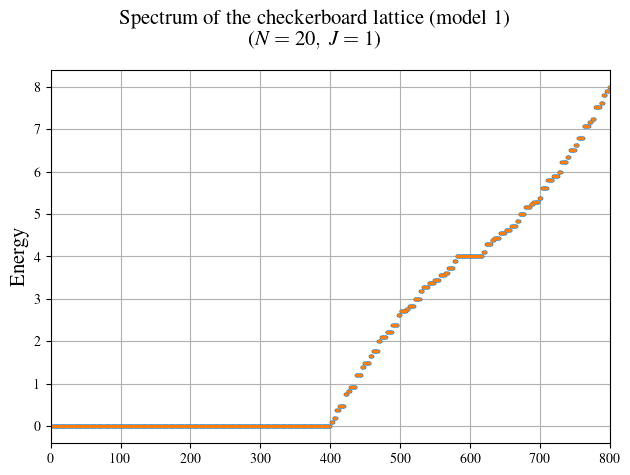

In [7]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Spectrum of the checkerboard lattice (model 1)\n"+f"($N={N},\; J=1$)", fontsize=15)

plt.scatter(np.arange(len(eigval1)),eigval1,s=3,zorder=2)
plt.scatter(np.arange(len(eigval1)),t,s=1,zorder=2)

plt.xlim(0,len(eigval1))
plt.ylabel("Energy", fontsize=15)
plt.grid(zorder=1)

plt.show()

In general, an eigenstates has the form
\begin{equation}
    |\Psi(\textbf{k})\rangle = c_a(\textbf{k}) |a_\textbf{k}\rangle + c_b(\textbf{k}) |b_\textbf{k}\rangle
\end{equation}
In the following, we plot the amplitude of $c_a$ and $c_b$ superimposed to the FBZ. Notice that the algorithm usually yields a state in which one out of $c_a$ or $c_b$ are purely real.

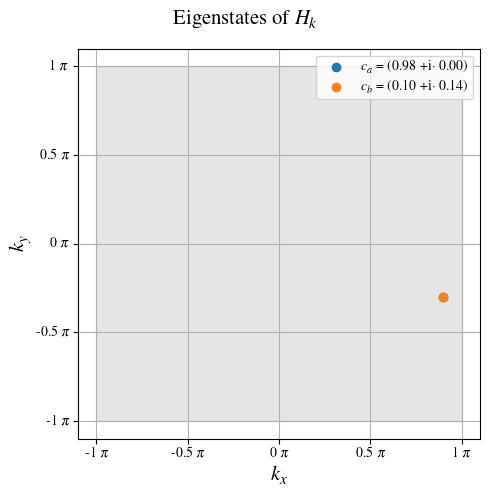

In [8]:
fig = plt.figure(tight_layout=1,figsize=(5,5))
ax = plt.axes()

s = 100
kx, ky = np.meshgrid(k+np.pi,k+np.pi)
ZA = eigvect1[::2,s].reshape((N,N))
ZB = eigvect1[1::2,s].reshape((N,N))

plt.suptitle(r"Eigenstates of $H_k$", fontsize=15)

if np.shape(ZA[ZA!=0])[0]==0:
    labelza = r"No amplitude of $c_a$"
else:
    labelza = f"$c_a$ = ({np.real(ZA[ZA!=0][0]):.2f}"+f" +i$\cdot$ {np.imag(ZA[ZA!=0][0]):.2f})"


if np.shape(ZB[ZB!=0])[0]==0:
    labelzb = r"No amplitude of $c_b$"
else:    
    labelzb = f"$c_b$ = ({np.real(ZB[ZB!=0][0]):.2f}"+f" +i$\cdot$ {np.imag(ZB[ZB!=0][0]):.2f})"
    
    
ax.fill_betweenx(np.linspace(-1,1,100),-1,1,alpha=0.2,color="grey")
ax.scatter(kx[ZA!=0]/np.pi, ky[ZA!=0]/np.pi,zorder=2, label=labelza)
ax.scatter(kx[ZB!=0]/np.pi, ky[ZB!=0]/np.pi,zorder=2, label=labelzb)

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)

ax.set_xlabel(r"$k_x$",fontsize=15)
ax.set_ylabel(r"$k_y$",fontsize=15)

ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g $\pi$'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g $\pi$'))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))

ax.grid(zorder=1)

plt.legend()
plt.show()

In [9]:
print("The considered eigenstate corresponds to the point k = "+
      f"({kx[ZA!=0][0]:.3f}, {ky[ZA!=0][0]:.3f})")

The considered eigenstate corresponds to the point k = (2.827, -0.942)


We Fourier-transform the eigenstate in order to get its real-space representation

In [10]:
PA = fft(eigvect1[::2,s]/N**2).reshape((N,N))
PB = fft(eigvect1[1::2,s]/N**2).reshape((N,N))

We plot the real and imaginary part of $c_a$.

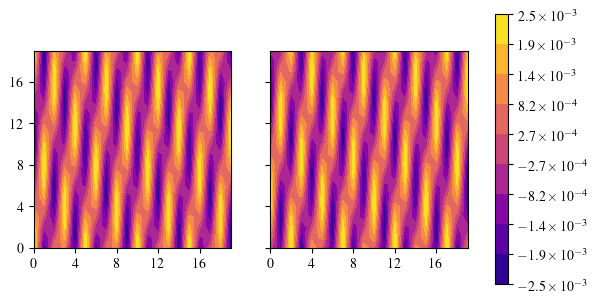

In [11]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1,figsize=(7,7))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

vmax = np.max(np.imag(PA))
vmin = np.min(np.real(PA))

pcm = ax[0].contourf(Nx,Ny,np.real(PA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.imag(PA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)
ax[1].set_xlim(0,N-1)
ax[0].set_yticks(np.arange(0,N,4))
ax[0].set_xticks(np.arange(0,N,4))
ax[1].set_xticks(np.arange(0,N,4))

cbar = fig.colorbar(pcm, ax = ax[:], shrink=0.5, format=ticker.FuncFormatter(fmt))
plt.show()

We plot the real and imaginary part of $c_b$.

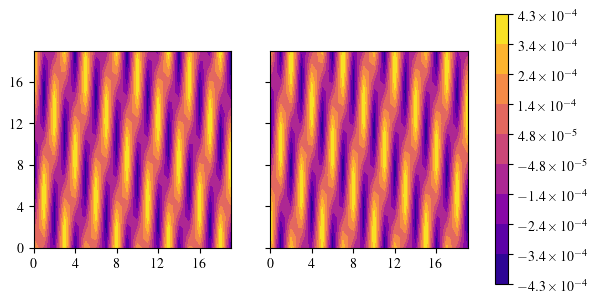

In [12]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1,figsize=(7,7))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

vmax = np.max(np.real(PB))
vmin = np.min(np.real(PB))

pcm = ax[0].contourf(Nx,Ny,np.real(PB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.imag(PB),cmap="plasma",levels = np.linspace(vmin,vmax,10))

ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)
ax[1].set_xlim(0,N-1)
ax[0].set_yticks(np.arange(0,N,4))
ax[0].set_xticks(np.arange(0,N,4))
ax[1].set_xticks(np.arange(0,N,4))

cbar = fig.colorbar(pcm, ax = ax[:], shrink=0.5, format=ticker.FuncFormatter(fmt))
plt.show()

## Second approach: FFT of $\mathcal{H}_{k}$

First, we define the $\vec{k}$ vector.

In [13]:
dk = 2*np.pi/N
k = np.linspace(-np.pi,np.pi-dk,N) - np.pi

kx, ky = np.meshgrid(k,k)

We define $\mathcal{H}_k$ as a block-matrix of the form
\begin{align}
    A \quad|\quad B\\
    B^\dagger\quad|\quad C
\end{align}
where $A$ is the block referring only to A-sites, $C$ only to B-sites, and $C$ to hoppings between A and B-sites.

In [14]:
A = np.diag(np.ravel(2 - 2*np.cos(ky)))
C = np.diag(np.ravel(2 - 2*np.cos(kx)))
B = -np.diag((1 - np.ravel(np.exp(-1.j*kx))) * (1 - np.ravel(np.exp(-1.j*ky))))

We now perform the FFT of each block individually and reassemble the block-matrix in real space.

In [15]:
A2 = np.roll(fft2(A/N**2)[::-1],1,axis=0)
C2 = np.roll(fft2(C/N**2)[::-1],1,axis=0)
B2 = np.roll(fft2(B/N**2)[::-1],1,axis=0)

In [16]:
H = np.block([
    [A2,B2],
    [np.transpose(np.conjugate(B2)),C2]
])

H = np.real(np.round(H,0))

We diagonalize the Hamiltonian.

In [17]:
eigval2, eigvect2 = eigh(H)

The comparison of the two spectra shows great accordance of the two and, most importantly, a perfect match of the value and the extent of the flat band.

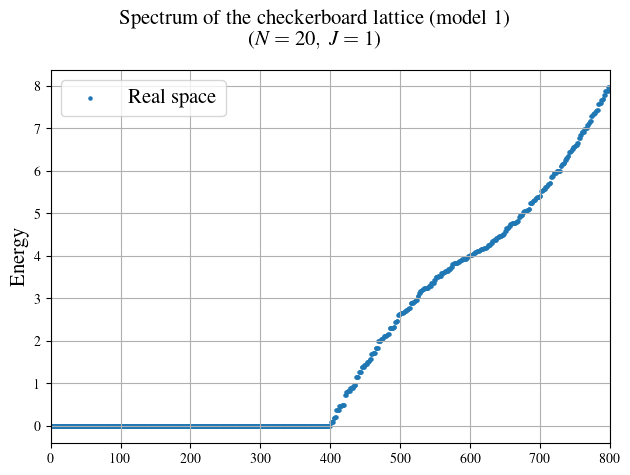

In [18]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Spectrum of the checkerboard lattice (model 1)\n"+f"($N={N},\; J=1$)", fontsize=15)

plt.scatter(np.arange(2*N**2),eigval2,s=5,label="Real space")

plt.xlim(0,2*N**2)
plt.ylabel("Energy", fontsize=15)
plt.grid(zorder=1)
plt.legend(fontsize=15)

plt.show()

Here, we plot an eigenstate in real space. On the left plot we have A-sites while on the right one we have B-sites.

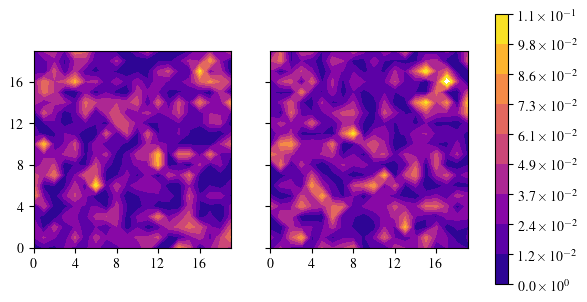

In [19]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1,figsize=(7,7))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

s = 10
state = np.transpose(eigvect2[:,s])
stateA = np.transpose(state[:N**2].reshape(N,N))
stateB = np.transpose(state[N**2:].reshape(N,N))

vmax = np.max(np.abs(stateA))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)
ax[1].set_xlim(0,N-1)
ax[0].set_yticks(np.arange(0,N,4))
ax[0].set_xticks(np.arange(0,N,4))
ax[1].set_xticks(np.arange(0,N,4))

cbar = fig.colorbar(pcm, ax = ax[:], shrink=0.5, format=ticker.FuncFormatter(fmt))
plt.show()

## Addendum: Open Boundary Conditions

We know want to generate the system using Open Boundary Conditions. In order to do so, we start again from the Hamiltonian in real space, as generated in the previous cells, and we $\textit{chop off}$ the first and the last row and coloumn. In this way, we can be sure that no effect due to periodicity in the boundaries will be taken into account.

We explore two different ways of terminating the lattice. In the first one, no Robust Boundary Modes arise whereas in the second one a RBM can be constructed. This highlights the dependance of those features on the edges.

### Configuration #1

In [126]:
dk = 2*np.pi/(N+2)
k = np.linspace(-np.pi,np.pi-dk,N+2) - np.pi

kx, ky = np.meshgrid(k,k)

In [127]:
A = np.diag(np.ravel(2 - 2*np.cos(ky)))
C = np.diag(np.ravel(2 - 2*np.cos(kx)))
B = -np.diag((1 - np.ravel(np.exp(-1.j*kx))) * (1 - np.ravel(np.exp(-1.j*ky))))

In [128]:
A2 = np.roll(fft2(A/(N+2)**2)[::-1],1,axis=0)
C2 = np.roll(fft2(C/(N+2)**2)[::-1],1,axis=0)
B2 = np.roll(fft2(B/(N+2)**2)[::-1],1,axis=0)

The chopping is performed here.

In [129]:
mask = np.ones(((N+2)**2,(N+2)**2),dtype="bool")
mask[:N+2,:] = mask[(N+2)*(N+1):,:] = False
mask[:,:N+2] = mask[:,(N+2)*(N+1):] = False
mask[::N+2,:] = mask[:,::N+2] = False
mask[N+1::N+2,:] = mask[:,N+1::N+2] = False

In [130]:
A2 = A2[mask].reshape(N**2,N**2)
B2 = B2[mask].reshape(N**2,N**2)
C2 = C2[mask].reshape(N**2,N**2)

In [131]:
H = np.block([
    [A2,B2],
    [np.transpose(np.conjugate(B2)),C2]
])

We diagonalize and plot the spectrum of the resulting Hamiltonian.

In [132]:
eigval3, eigvect3 = eigh(H)

As we can see, the spectrum gets deformed around the band touching point. This is a numerical artifact which becomes negligible in the thermodynamical limit.

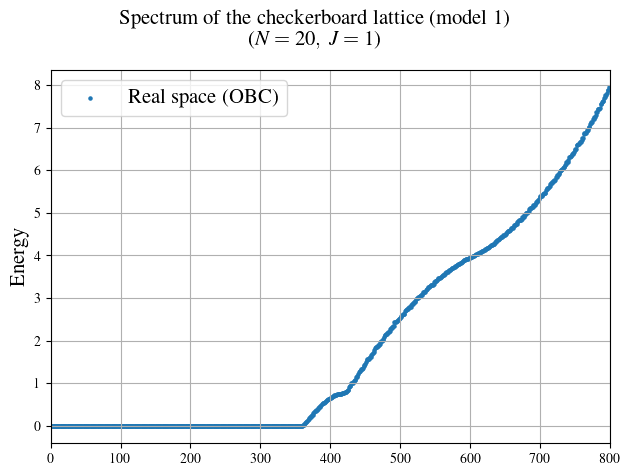

In [133]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Spectrum of the checkerboard lattice (model 1)\n"+f"($N={N},\; J=1$)", fontsize=15)

plt.scatter(np.arange(len(eigval3)),eigval3,s=5,label="Real space (OBC)")

plt.xlim(0,2*N**2)
plt.ylabel("Energy", fontsize=15)
plt.grid(zorder=1)
plt.legend(fontsize=15)

plt.show()

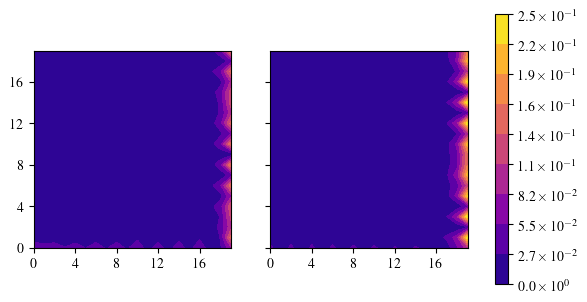

In [78]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1,figsize=(7,7))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))


s = 400
state = eigvect3[:,s]
stateA = np.transpose(state[:N**2].reshape(N,N))
stateB = np.transpose(state[N**2:].reshape(N,N))

vmax = np.max(np.abs(stateB))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)
ax[1].set_xlim(0,N-1)
ax[0].set_yticks(np.arange(0,N,4))
ax[0].set_xticks(np.arange(0,N,4))
ax[1].set_xticks(np.arange(0,N,4))

cbar = fig.colorbar(pcm, ax = ax[:], shrink=0.5, format=ticker.FuncFormatter(fmt))
plt.show()

#### Boundary modes

In [212]:
bm_disp = eigval3[eigval3<=0.8][N*(N-2):]
bm = eigvect3[:,eigval3<=0.8][:,N*(N-2):]

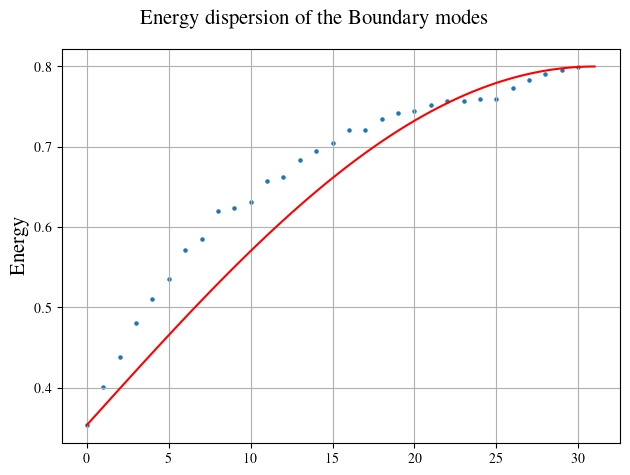

In [339]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Energy dispersion of the Boundary modes",fontsize=15)
plt.scatter(np.arange(len(ind)),bm_disp[ind],s=5)
x = np.linspace(0,np.pi/2,100)
plt.plot(np.linspace(0,len(ind),100),bm_disp[ind][0] + 0.446*np.sin(x),c="red",label="Sine-band")

plt.ylabel("Energy", fontsize=15)
plt.grid(zorder=1)
#plt.legend(fontsize=15)

plt.show()

In [338]:
0.8-bm_disp[ind][0]

0.44619638163648145

In [324]:
normA = []
normB = []
for s in range(len(bm_disp)):
    state = bm[:,s]
    stateA = np.transpose(state[:N**2].reshape(N,N))
    stateB = np.transpose(state[N**2:].reshape(N,N))
    
    normA.append(norm(stateA[:,-1])+norm(stateB[:,-1]))# + norm(stateA[0,:]))
    normB.append(norm(stateA[0,:])+ norm(stateB[0,:]))
normA = np.array(normA)/max(normA)
normB = np.array(normB)/max(normB)

In [325]:
arr = np.arange(0,len(bm_disp),1)
arr1 = arr[normA>0.6]
arr1 = np.append(arr1,arr[normB>0.6])

In [328]:
ind = np.unique(arr1)

In [340]:
len(ind)

31

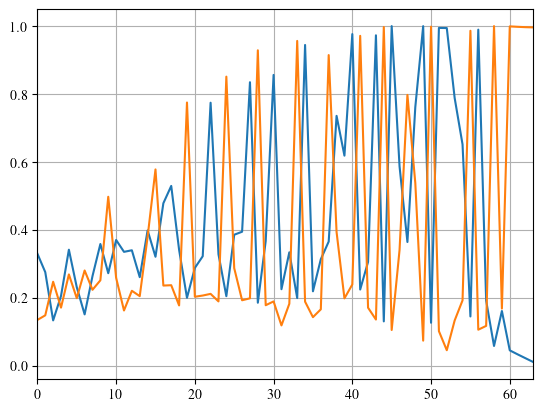

In [327]:
fig = plt.figure()

plt.plot(normA)
plt.plot(normB)

plt.xlim(0,63)
plt.grid()
#plt.ylim(0.6)
#plt.plot(normB)

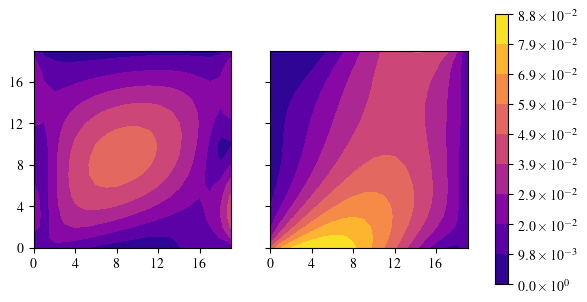

In [345]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1,figsize=(7,7))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))


s = 2
state = bm[:,s]
stateA = np.transpose(state[:N**2].reshape(N,N))
stateB = np.transpose(state[N**2:].reshape(N,N))

vmax = np.max(np.abs(stateB))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)
ax[1].set_xlim(0,N-1)
ax[0].set_yticks(np.arange(0,N,4))
ax[0].set_xticks(np.arange(0,N,4))
ax[1].set_xticks(np.arange(0,N,4))

cbar = fig.colorbar(pcm, ax = ax[:], shrink=0.5, format=ticker.FuncFormatter(fmt))
plt.show()

### Second way to terminate the edges

In [31]:
dk = 2*np.pi/(N+2)
k = np.linspace(-np.pi,np.pi-dk,N+2) - np.pi

kx, ky = np.meshgrid(k,k)

In [32]:
A = np.diag(np.ravel(2 - 2*np.cos(ky)))
C = np.diag(np.ravel(2 - 2*np.cos(kx)))
B = -np.diag((1 - np.ravel(np.exp(-1.j*kx))) * (1 - np.ravel(np.exp(-1.j*ky))))

In [33]:
A2 = np.roll(fft2(A/(N+2)**2)[::-1],1,axis=0)
C2 = np.roll(fft2(C/(N+2)**2)[::-1],1,axis=0)
B2 = np.roll(fft2(B/(N+2)**2)[::-1],1,axis=0)

In [34]:
mask = np.ones(((N+2)**2,(N+2)**2),dtype="bool")
mask[:N+2,:] = mask[(N+2)*(N+1):,:] = False
mask[:,:N+2] = mask[:,(N+2)*(N+1):] = False
mask[::N+2,:] = mask[:,::N+2] = False
mask[N+1::N+2,:] = mask[:,N+1::N+2] = False

In [35]:
A2 = A2[mask].reshape(N**2,N**2)
B2 = B2[mask].reshape(N**2,N**2)
C2 = C2[mask].reshape(N**2,N**2)

In [36]:
H = np.block([
    [A2,B2],
    [np.transpose(np.conjugate(B2)),C2]
])

H = np.round(H,0)
H[:N**2:N,:] = H[:,:N**2:N] = 0
H[N*(2*N-1):,:] = H[:,N*(2*N-1):] = 0

We now diagonalize the Hamiltonian.

In [41]:
eigval4, eigvect4 = eigh(H)

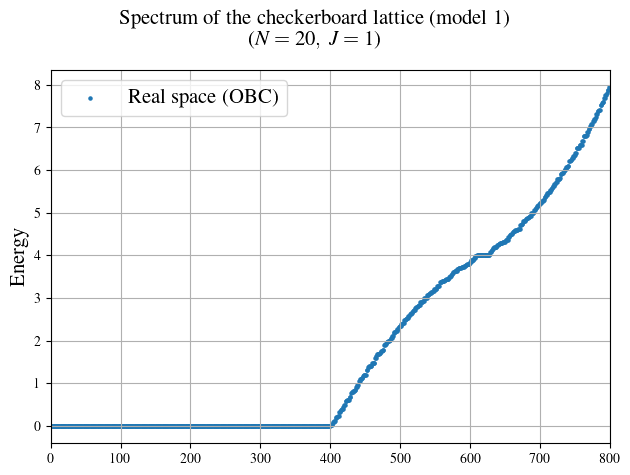

In [42]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Spectrum of the checkerboard lattice (model 1)\n"+f"($N={N},\; J=1$)", fontsize=15)

plt.scatter(np.arange(len(eigval4)),eigval4,s=5,label="Real space (OBC)")

plt.xlim(0,2*N**2)
plt.ylabel("Energy", fontsize=15)
plt.grid(zorder=1)
plt.legend(fontsize=15)

plt.show()

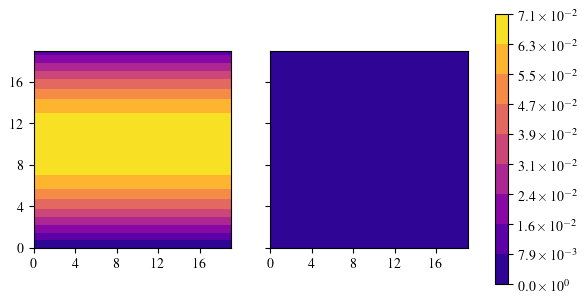

In [56]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1,figsize=(7,7))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))


s = 402
state = eigvect4[:,s]
stateA = np.transpose(state[:N**2].reshape(N,N))
stateB = np.transpose(state[N**2:].reshape(N,N))

vmax = np.max(np.abs(stateA))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)
ax[1].set_xlim(0,N-1)
ax[0].set_yticks(np.arange(0,N,4))
ax[0].set_xticks(np.arange(0,N,4))
ax[1].set_xticks(np.arange(0,N,4))

cbar = fig.colorbar(pcm, ax = ax[:], shrink=0.5, format=ticker.FuncFormatter(fmt))
plt.show()

# Comparison of the four spectra

The three spectra are comparable one with each other, other than around the band touching where numerical effects arises. Those effects though become negligible in the thermodynamical limit ($N\to+\infty$).

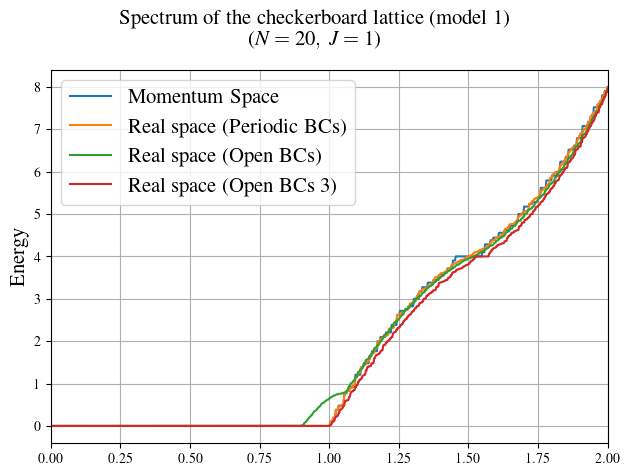

In [75]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Spectrum of the checkerboard lattice (model 1)\n"+f"($N={N},\; J=1$)", fontsize=15)

plt.plot(np.linspace(0,2,2*N**2),eigval1,label="Momentum Space")
plt.plot(np.linspace(0,2,2*N**2),eigval2,label="Real space (Periodic BCs)")
plt.plot(np.linspace(0,2,2*N**2),eigval3,label="Real space (Open BCs)")
plt.plot(np.linspace(0,2,2*N**2),eigval4,label="Real space (Open BCs 3)")

plt.xlim(0,2)
plt.ylabel("Energy", fontsize=15)
plt.grid(zorder=1)
plt.legend(fontsize=15)
plt.show()